
# Alpha 因子评估

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

import os, sys
from time import time

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import scale
import lightgbm as lgb
from scipy.stats import spearmanr
from tqdm import tqdm
import shap

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [5]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

In [6]:
results_path = Path('results')
if not results_path.exists():
    results_path.mkdir()

## 加载数据

In [14]:
factors = (pd.concat([pd.read_hdf('cn_data.h5', 'factors/common'),
                      pd.read_hdf('cn_data.h5', 'factors/formulaic')
                      .rename(columns=lambda x: f'alpha_{int(x):03}')],
                     axis=1)
           .dropna(axis=1)
           .sort_index())

In [15]:
factors.head()

code_name industry  sector   ret_fwd       BOP        AD  \
code      date                                                                  
sh.600030 2017-07-04      中信证券     非银金融       5  0.008368 -0.761905 -0.319917   
          2017-07-05      中信证券     非银金融       5 -0.008299  0.631579  0.074287   
          2017-07-06      中信证券     非银金融       5  0.013150 -0.607143 -0.236388   
          2017-07-07      中信证券     非银金融       5  0.003540  0.600000  0.180643   
          2017-07-10      中信证券     非银金融       5  0.008818  0.250000 -0.165945   

                      size_factor   size_proxy  alpha_021  alpha_023  ...  \
code      date                                                        ...   
sh.600030 2017-07-04     1.000000  2256.380770          1        0.0  ...   
          2017-07-05     1.008368  2275.262618          1        0.0  ...   
          2017-07-06     1.000000  2256.380770          1        0.0  ...   
          2017-07-07     1.013150  2286.052245          1        0.0  ...   
          2017-07-10     1.016736  2294.144465          1        0.0  ...   

                      alpha_062  alpha_064  alpha_065  alpha_068  alpha_074  \
code      date                                                                
sh.600030 2017-07-04          0          0          0          0          0   
          2017-07-05          0          0          0          0          0   
          2017-07-06          0          0          0          0          0   
          2017-07-07          0          0          0          0          0   
          2017-07-10          0          0          0          0          0   

                      alpha_075  alpha_081  alpha_086  alpha_095  alpha_099  
code      date                                                               
sh.600030 2017-07-04          0          0          0          0          0  
          2017-07-05          0          0          0          0          0  
          2017-07-06          0          0          0          0          0  
          2017-07-07          0          0          0          0          0  
          2017-07-10          0          0          0          0          0  

[5 rows x 23 columns]

In [16]:
factors.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 72550 entries, ('sh.600030', Timestamp('2017-07-04 00:00:00')) to ('sz.300274', Timestamp('2023-06-20 00:00:00'))
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   code_name    72550 non-null  object 
 1   industry     72550 non-null  object 
 2   sector       72550 non-null  int64  
 3   ret_fwd      72550 non-null  float64
 4   BOP          72550 non-null  float64
 5   AD           72550 non-null  float64
 6   size_factor  72550 non-null  float64
 7   size_proxy   72550 non-null  float64
 8   alpha_021    72550 non-null  int32  
 9   alpha_023    72550 non-null  float64
 10  alpha_027    72550 non-null  float64
 11  alpha_041    72550 non-null  float64
 12  alpha_061    72550 non-null  int32  
 13  alpha_062    72550 non-null  int32  
 14  alpha_064    72550 non-null  int32  
 15  alpha_065    72550 non-null  int32  
 16  alpha_068    72550 non-null  int32  
 17  

In [68]:
fwd_returns = factors.filter(like='fwd').columns
features = factors.columns.difference(fwd_returns).tolist()
features.remove('code_name')
features.remove('industry')
alphas = pd.Index([f for f in features if f.startswith('alpha')])

In [69]:
features

['AD',
 'BOP',
 'alpha_021',
 'alpha_023',
 'alpha_027',
 'alpha_041',
 'alpha_061',
 'alpha_062',
 'alpha_064',
 'alpha_065',
 'alpha_068',
 'alpha_074',
 'alpha_075',
 'alpha_081',
 'alpha_086',
 'alpha_095',
 'alpha_099',
 'sector',
 'size_factor',
 'size_proxy']

In [65]:
len(alphas)

15

## 因子相关性

###“经典”因子

In [20]:
corr_common = factors.drop(fwd_returns.union(alphas), axis=1).corr(method='spearman')

In [22]:
corr_common.to_hdf('cn_data.h5', 'correlation/common')

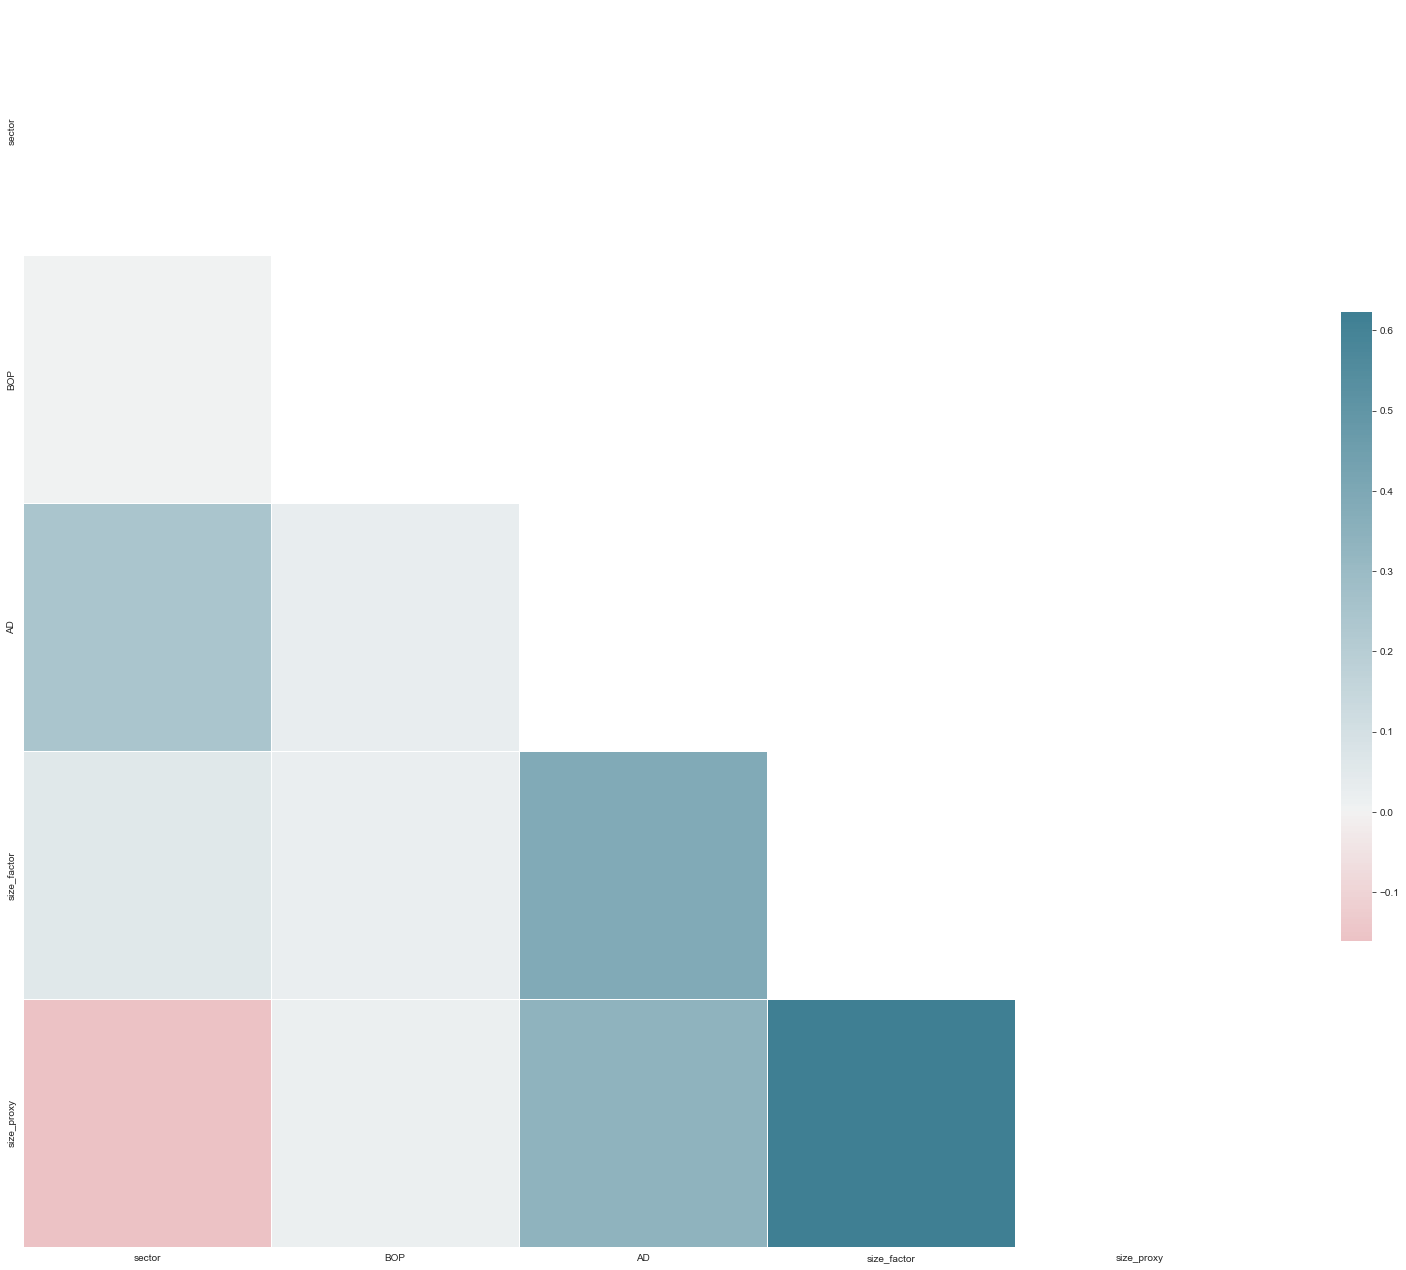

In [23]:
mask = np.triu(np.ones_like(corr_common, dtype=np.bool))
fig, ax = plt.subplots(figsize=(22, 18))
cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr_common, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
fig.tight_layout()
fig.savefig(results_path / 'factor_corr_common', dpi=300);

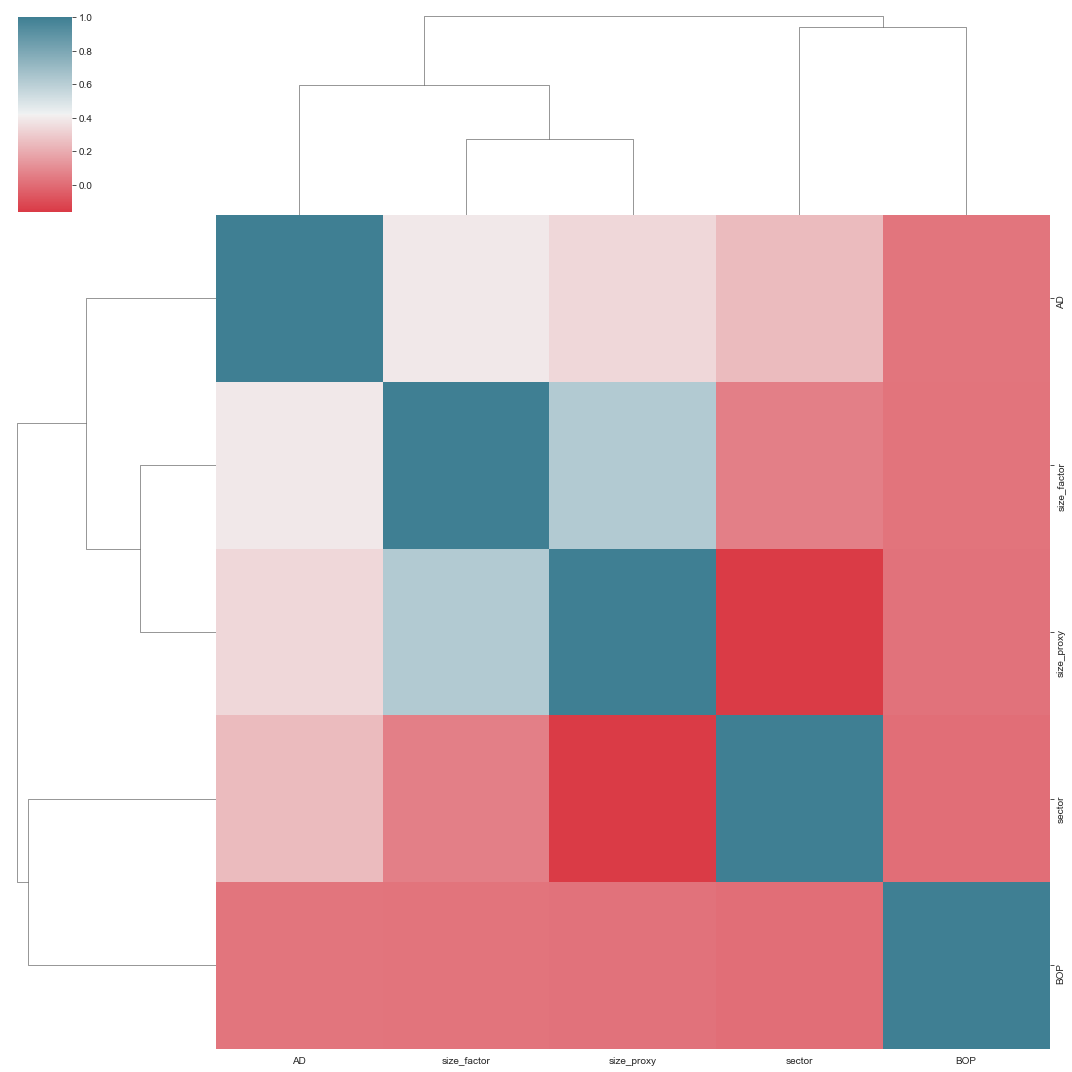

In [24]:
g = sns.clustermap(corr_common, cmap=cmap, figsize=(15, 15))
g.savefig(results_path / 'factor_corr_common_cluster', dpi=300);

In [25]:
corr_ = corr_common.stack().reset_index()
corr_.columns = ['x1', 'x2', 'rho']
corr_ = corr_[corr_.x1!=corr_.x2].drop_duplicates('rho')

In [26]:
corr_.nlargest(5, columns='rho').append(corr_.nsmallest(5, columns='rho'))

,x1,x2,rho
19,size_factor,size_proxy,0.622539
13,AD,size_factor,0.388562
14,AD,size_proxy,0.336447
2,sector,AD,0.244245
3,sector,size_factor,0.057597
4,sector,size_proxy,-0.161415
1,sector,BOP,0.005362
9,BOP,size_proxy,0.016743
8,BOP,size_factor,0.024084
7,BOP,AD,0.027622


### 阿尔法公式

In [27]:
%%time
corr_formula = factors[alphas].sort_index().corr(method='spearman').dropna(how='all', axis=1)
corr_formula.to_hdf('data.h5', 'correlation/formula')

CPU times: total: 62.5 ms
Wall time: 1.16 s


In [28]:
corr_formula = corr_formula.dropna(how='all').dropna(how='all', axis=1)

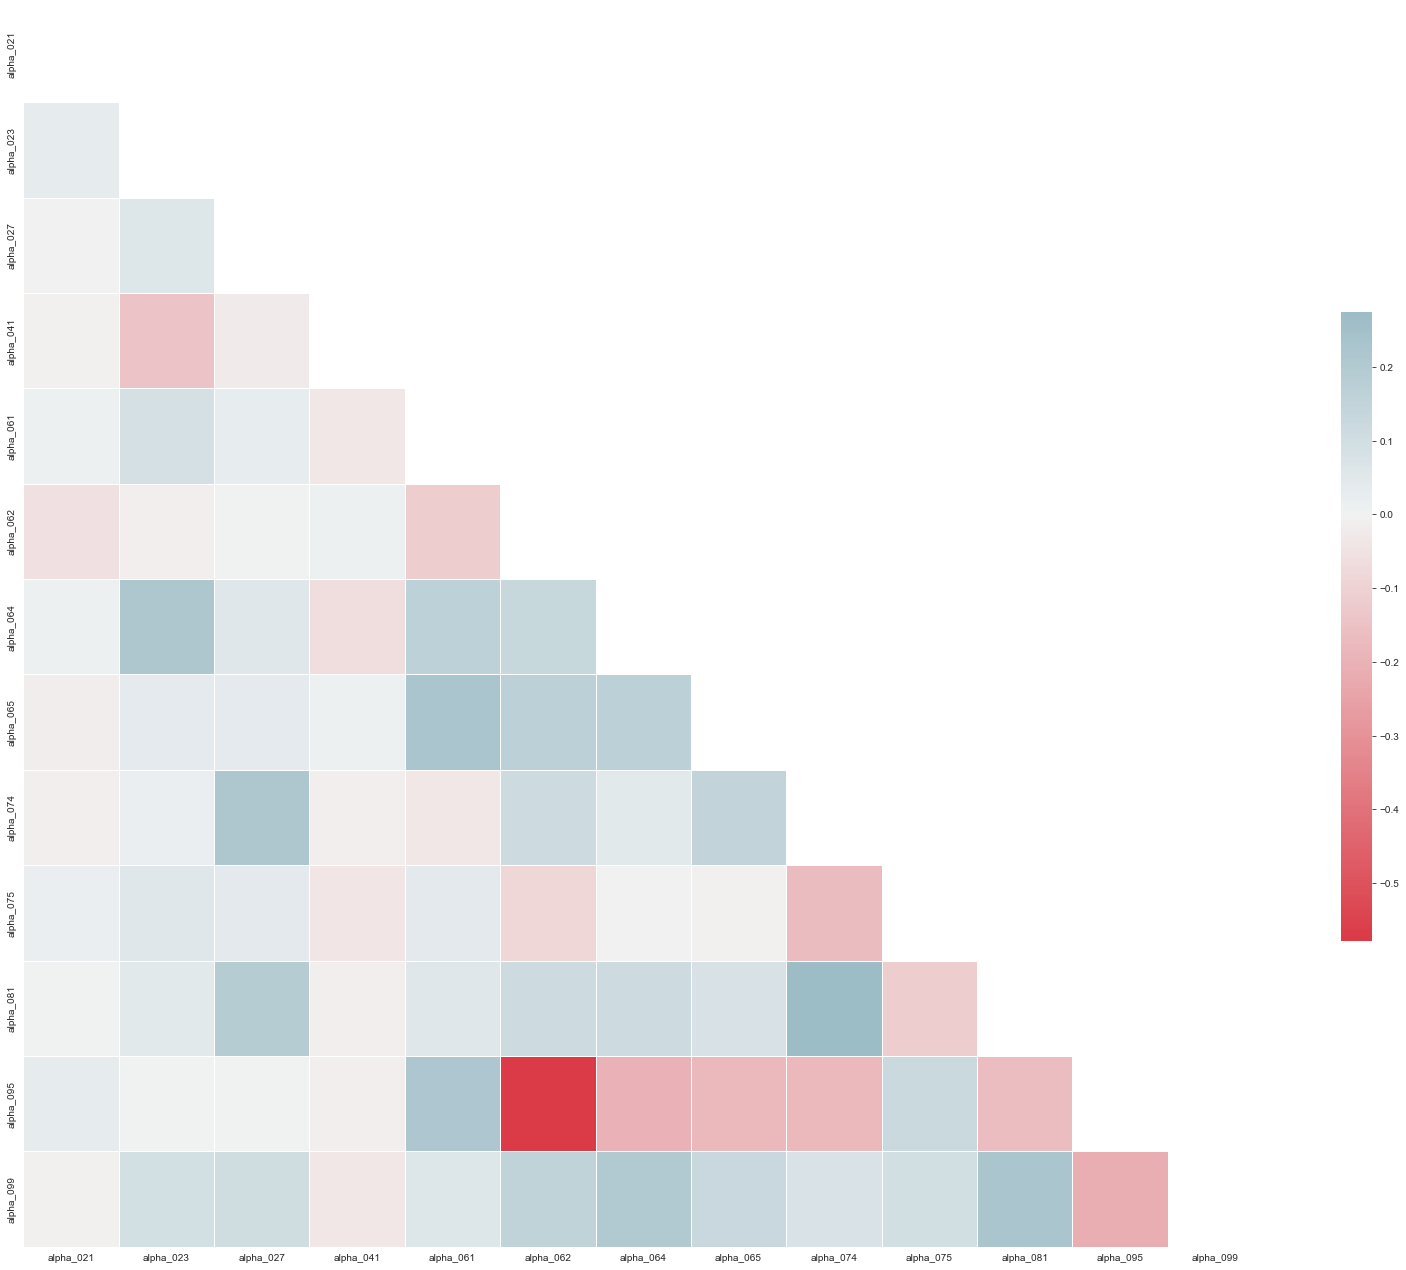

In [29]:
mask = np.triu(np.ones_like(corr_formula, dtype=np.bool))
fig, ax = plt.subplots(figsize=(22, 18))
cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr_formula, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
fig.tight_layout()
fig.savefig(results_path / 'factor_correlation_formula', dpi=300);

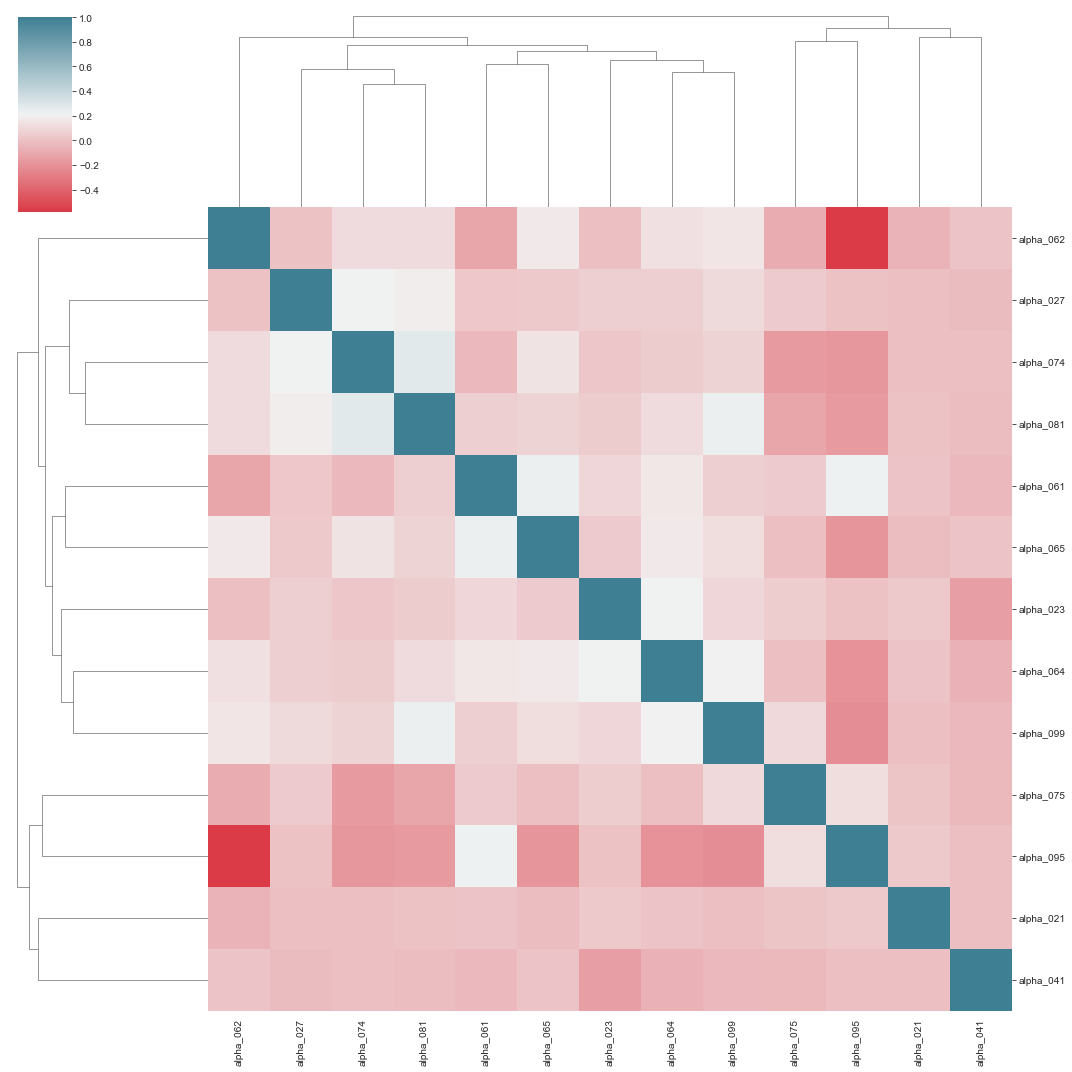

In [30]:
g = sns.clustermap(corr_formula.replace((np.inf, -np.inf), np.nan), cmap=cmap, figsize=(15, 15))
g.savefig(results_path / 'factor_correlation_formula_cluster', dpi=300);

In [31]:
corr_formula_ = corr_formula.stack().reset_index()
corr_formula_.columns = ['x1', 'x2', 'rho']
corr_formula_ = corr_formula_[corr_formula_.x1!=corr_formula_.x2].drop_duplicates('rho')

In [32]:
corr_formula_.nlargest(5, columns='rho').append(corr_formula_.nsmallest(5, columns='rho'))

,x1,x2,rho
114,alpha_074,alpha_081,0.274117
142,alpha_081,alpha_099,0.230038
59,alpha_061,alpha_065,0.228988
63,alpha_061,alpha_095,0.219011
19,alpha_023,alpha_064,0.213969
76,alpha_062,alpha_095,-0.579056
155,alpha_095,alpha_099,-0.215504
89,alpha_064,alpha_095,-0.199846
102,alpha_065,alpha_095,-0.184761
115,alpha_074,alpha_095,-0.182658


### 所有因子

In [34]:
factors.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 72550 entries, ('sh.600030', Timestamp('2017-07-04 00:00:00')) to ('sz.300274', Timestamp('2023-06-20 00:00:00'))
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   code_name    72550 non-null  object 
 1   industry     72550 non-null  object 
 2   sector       72550 non-null  int64  
 3   ret_fwd      72550 non-null  float64
 4   BOP          72550 non-null  float64
 5   AD           72550 non-null  float64
 6   size_factor  72550 non-null  float64
 7   size_proxy   72550 non-null  float64
 8   alpha_021    72550 non-null  int32  
 9   alpha_023    72550 non-null  float64
 10  alpha_027    72550 non-null  float64
 11  alpha_041    72550 non-null  float64
 12  alpha_061    72550 non-null  int32  
 13  alpha_062    72550 non-null  int32  
 14  alpha_064    72550 non-null  int32  
 15  alpha_065    72550 non-null  int32  
 16  alpha_068    72550 non-null  int32  
 17  

In [35]:
corr = factors.drop(['ret_fwd', 'alpha_061'], axis=1).corr()

In [36]:
corr = corr.dropna(how='all').dropna(how='all', axis=1)

In [38]:
corr.to_hdf('cn_data.h5', 'correlation/all')

In [39]:
corr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, sector to alpha_099
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sector       17 non-null     float64
 1   BOP          17 non-null     float64
 2   AD           17 non-null     float64
 3   size_factor  17 non-null     float64
 4   size_proxy   17 non-null     float64
 5   alpha_021    17 non-null     float64
 6   alpha_023    17 non-null     float64
 7   alpha_027    17 non-null     float64
 8   alpha_041    17 non-null     float64
 9   alpha_062    17 non-null     float64
 10  alpha_064    17 non-null     float64
 11  alpha_065    17 non-null     float64
 12  alpha_074    17 non-null     float64
 13  alpha_075    17 non-null     float64
 14  alpha_081    17 non-null     float64
 15  alpha_095    17 non-null     float64
 16  alpha_099    17 non-null     float64
dtypes: float64(17)
memory usage: 2.4+ KB


In [40]:
corr.shape

(17, 17)

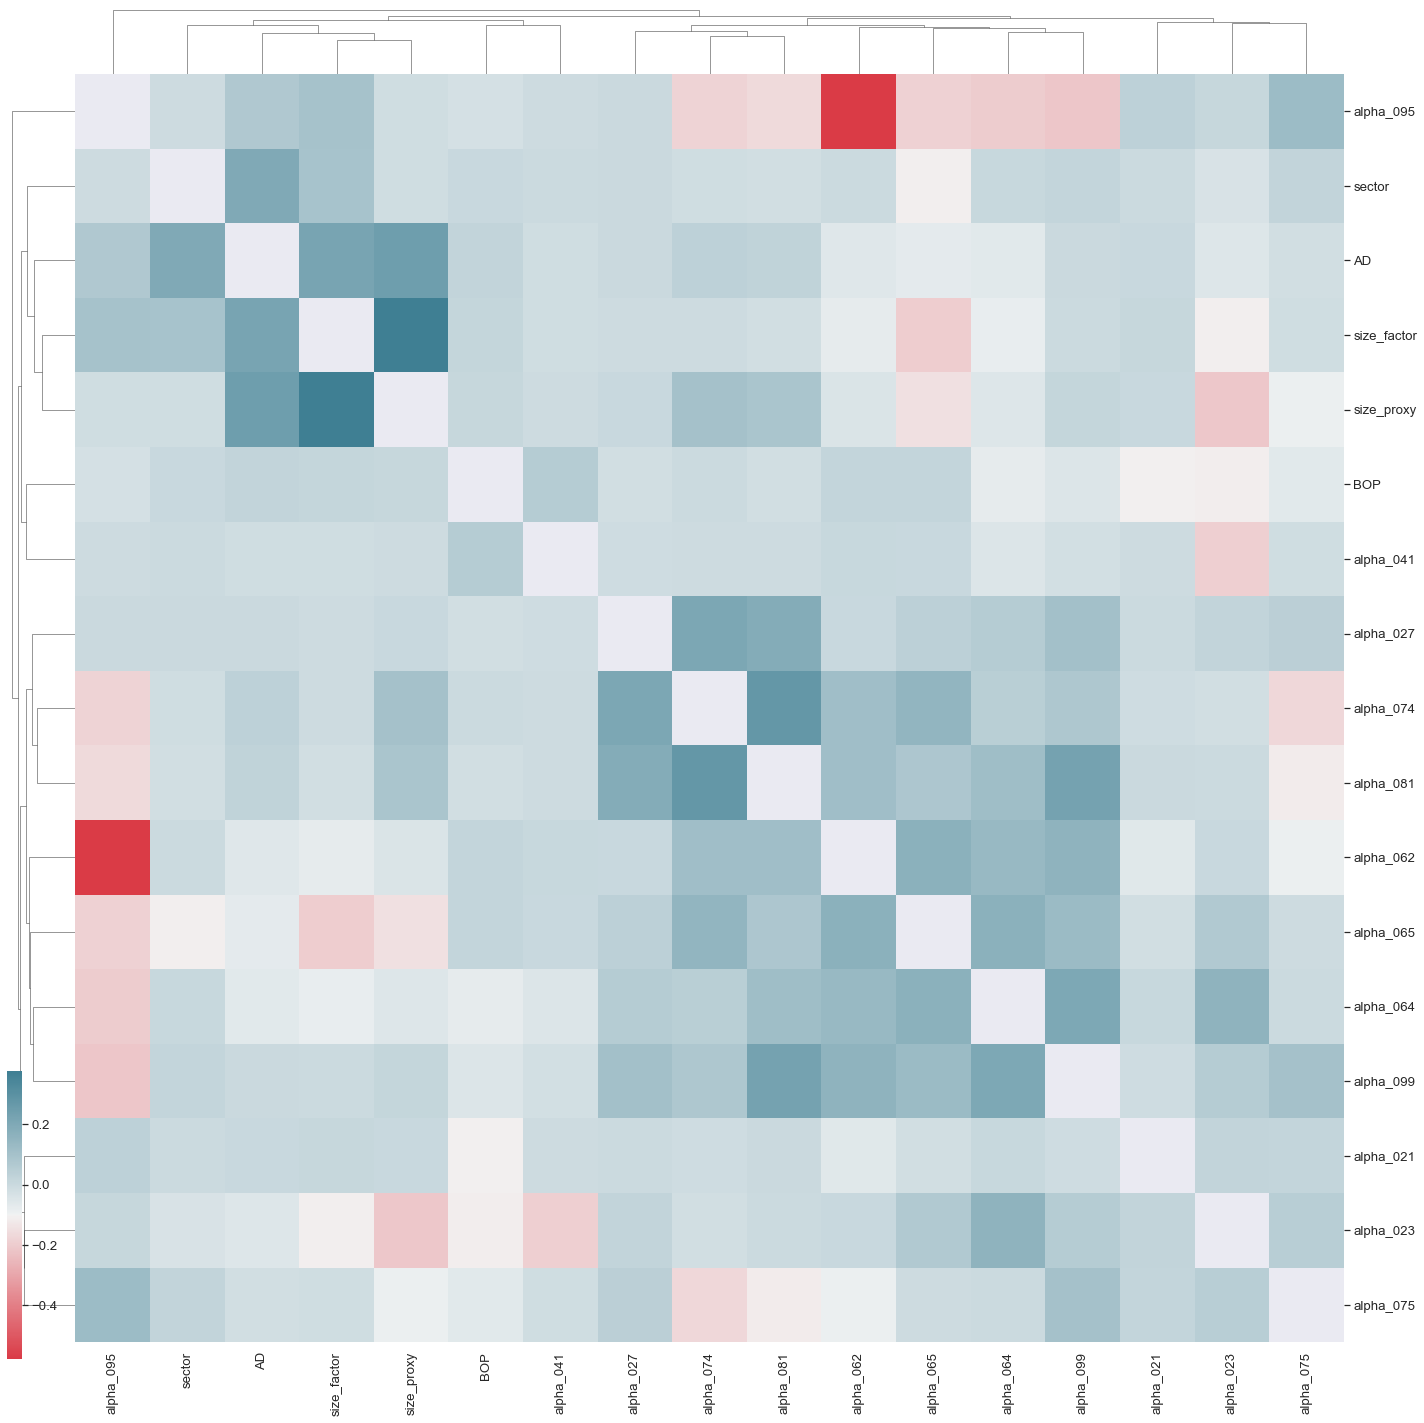

In [41]:
sns.set(font_scale=1.2)

mask = np.zeros_like(corr)
np.fill_diagonal(mask, 1)

g = sns.clustermap(corr, 
                   cmap=cmap, 
                   figsize=(20, 20), 
                   dendrogram_ratio=.05,
                   mask=mask,
                   cbar_pos=(0.01, 0.05, 0.01, 0.2));

g.savefig(results_path / 'factor_correlation_all', dpi=300);

## 正向回报相关性

In [42]:
fwd_corr = factors.drop(['ret_fwd', 'alpha_061'], axis=1).corrwith(factors.ret_fwd, method='spearman')

In [43]:
fwd_corr = fwd_corr.dropna()

In [45]:
fwd_corr.to_hdf('cn_data.h5', 'correlation/fwd_ret')

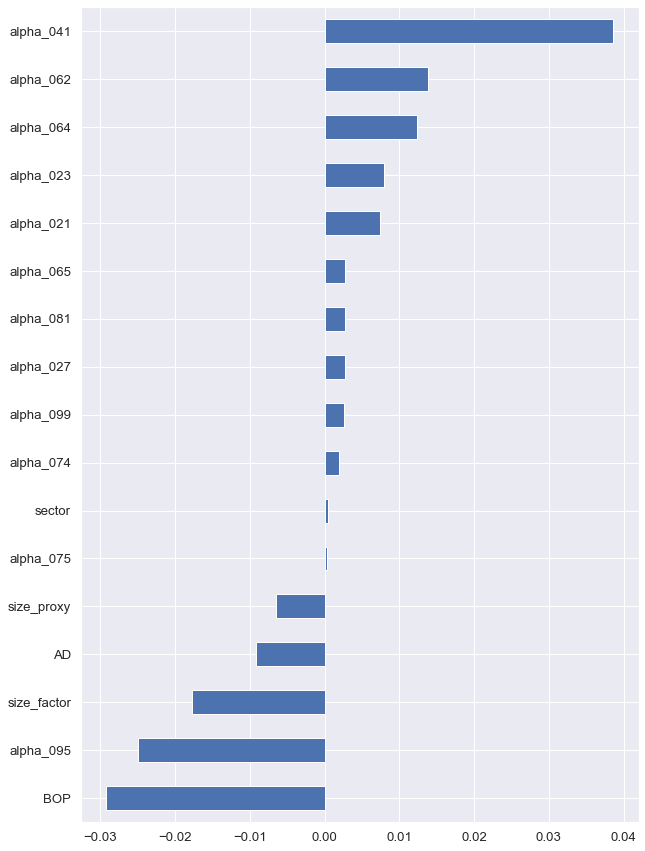

In [46]:
top50 = fwd_corr.abs().nlargest(50).index
fwd_corr.loc[top50].sort_values().plot.barh(figsize=(10, 15),
                                            legend=False);

## 互信息

In [62]:
features

['AD',
 'BOP',
 'alpha_021',
 'alpha_023',
 'alpha_027',
 'alpha_041',
 'alpha_061',
 'alpha_062',
 'alpha_064',
 'alpha_065',
 'alpha_068',
 'alpha_074',
 'alpha_075',
 'alpha_081',
 'alpha_086',
 'alpha_095',
 'alpha_099',
 'code_name',
 'industry',
 'sector',
 'size_factor',
 'size_proxy']

In [70]:
mi = {}
for feature in tqdm(features):
    df = (factors
          .loc[:, ['ret_fwd', feature]]
          .dropna().sample(n=10000))
    discrete_features = df[feature].nunique() < 10
    mi[feature] = mutual_info_regression(X=df[[feature]],
                                         y=df.ret_fwd,
                                         discrete_features=discrete_features)[0]
mi = pd.Series(mi)

100%|██████████| 20/20 [00:01<00:00, 16.01it/s]


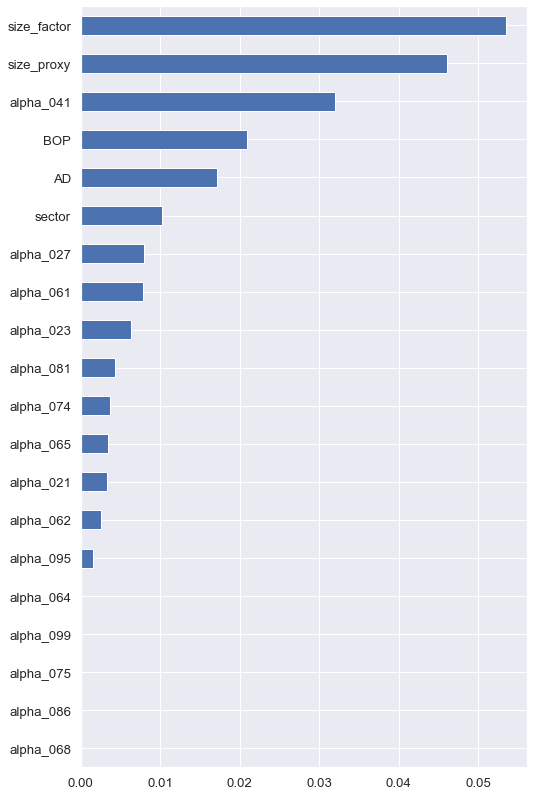

In [71]:
mi.nlargest(50).sort_values().plot.barh(figsize=(8, 14));

In [72]:
mi.to_hdf('cn_data.h5', 'mutual_information')

## LightGBM 功能重要性

In [73]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

In [74]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

In [52]:
uniques = factors.nunique()

In [53]:
categoricals = uniques[uniques < 20].index.tolist()

In [76]:
categoricals

['industry',
 'sector',
 'alpha_021',
 'alpha_027',
 'alpha_061',
 'alpha_062',
 'alpha_064',
 'alpha_065',
 'alpha_068',
 'alpha_074',
 'alpha_075',
 'alpha_081',
 'alpha_086',
 'alpha_095',
 'alpha_099']

In [75]:
features = factors.columns.difference(fwd_returns).tolist()

In [56]:
label = 'ret_fwd'

In [57]:
train_length = int(8.5 * 252)
test_length = 252
n_splits = 1

In [58]:
params = dict(boosting='gbdt',
              objective='regression',
              verbose=-1,
              metric='None')
num_boost_round = 5000

In [78]:
factors

code_name industry  sector   ret_fwd       BOP  \
code      date                                                        
sh.600030 2017-07-04      中信证券     非银金融       5  0.008368 -0.761905   
          2017-07-05      中信证券     非银金融       5 -0.008299  0.631579   
          2017-07-06      中信证券     非银金融       5  0.013150 -0.607143   
          2017-07-07      中信证券     非银金融       5  0.003540  0.600000   
          2017-07-10      中信证券     非银金融       5  0.008818  0.250000   
...                        ...      ...     ...       ...       ...   
sz.300274 2023-06-14      阳光电源     电气设备      11  0.073665 -0.452381   
          2023-06-15      阳光电源     电气设备      11  0.029972  0.747976   
          2023-06-16      阳光电源     电气设备      11 -0.001227  0.560241   
          2023-06-19      阳光电源     电气设备      11 -0.003423  0.281899   
          2023-06-20      阳光电源     电气设备      11 -0.003610 -0.012987   

                             AD  size_factor    size_proxy  alpha_021  \
code      date                                                          
sh.600030 2017-07-04  -0.319917     1.000000   2256.380770          1   
          2017-07-05   0.074287     1.008368   2275.262618          1   
          2017-07-06  -0.236388     1.000000   2256.380770          1   
          2017-07-07   0.180643     1.013150   2286.052245          1   
          2017-07-10  -0.165945     1.016736   2294.144465          1   
...                         ...          ...           ...        ...   
sz.300274 2023-06-14 -21.218673     9.178826  11729.249854          1   
          2023-06-15 -20.308197     9.854982  12593.282992          1   
          2023-06-16 -19.669524    10.150356  12970.729048          1   
          2023-06-19 -19.740268    10.137900  12954.812648          1   
          2023-06-20 -19.919056    10.103203  12910.474105          1   

                      alpha_023  ...  alpha_062  alpha_064  alpha_065  \
code      date                   ...                                    
sh.600030 2017-07-04       0.00  ...          0          0          0   
          2017-07-05       0.00  ...          0          0          0   
          2017-07-06       0.00  ...          0          0          0   
          2017-07-07       0.00  ...          0          0          0   
          2017-07-10       0.00  ...          0          0          0   
...                         ...  ...        ...        ...        ...   
sz.300274 2023-06-14       0.00  ...         -1          0         -1   
          2023-06-15      -6.21  ...         -1          0         -1   
          2023-06-16      -8.70  ...         -1          0         -1   
          2023-06-19      -3.87  ...         -1         -1         -1   
          2023-06-20      -0.74  ...         -1         -1         -1   

                      alpha_068  alpha_074  alpha_075  alpha_081  alpha_086  \
code      date                                                                
sh.600030 2017-07-04          0          0          0          0          0   
          2017-07-05          0          0          0          0          0   
          2017-07-06          0          0          0          0          0   
          2017-07-07          0          0          0          0          0   
          2017-07-10          0          0          0          0          0   
...                         ...        ...        ...        ...        ...   
sz.300274 2023-06-14          0         -1          1         -1          0   
          2023-06-15          0          0          1          0          0   
          2023-06-16          0         -1          1         -1          0   
          2023-06-19          0          0          1          0          0   
          2023-06-20          0          0          1          0          0   

                      alpha_095  alpha_099  
code      date                              
sh.600030 2017-07-04          0          0  
          2017-07-05          0   

In [77]:
lgb_data = lgb.Dataset(data=factors.loc[:, features],
                       label=factors.loc[:, label],
                       categorical_feature=categoricals,
                       free_raw_data=False)

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          lookahead=1,
                          test_period_length=test_length,
                          train_period_length=train_length)

feature_importance, ic, daily_ic = [], [], []

for i, (train_idx, test_idx) in enumerate(cv.split(X=factors)):
    start = time()
    lgb_train = lgb_data.subset(used_indices=train_idx.tolist(),
                               params=params).construct()
    lgb_test = lgb_data.subset(used_indices=test_idx.tolist(),
                               params=params).construct()
    evals_result = {}
    model = lgb.train(params=params,
                      train_set=lgb_train,
                      num_boost_round=num_boost_round,
                      valid_sets=[lgb_train, lgb_test],
                      valid_names=['train', 'valid'],
                      feval=ic_lgbm,
                      evals_result=evals_result,
                      early_stopping_rounds=500,
                      verbose_eval=100)
    model.save_model(f'models/lgb_model.txt')
    fi = get_fi(model)
    fi.to_hdf('data.h5', f'fi/{i:02}')
    test_set = factors.iloc[test_idx, :]
    X_test = test_set.loc[:, model.feature_name()]
    y_test = test_set.loc[:, label]
    y_pred = model.predict(X_test)
    cv_preds = y_test.to_frame('y_test').assign(y_pred=y_pred)
    cv_preds.to_hdf('preds.h5', f'preds/{i:02}')

    by_day = cv_preds.groupby(level='date')
    ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x.y_pred)[0])
    daily_ic_mean = ic_by_day.mean()
    daily_ic_median = ic_by_day.median()
    ic = spearmanr(cv_preds.y_test, cv_preds.y_pred)[0]
    print(f'\n{time()-start:6.1f} | {ic:6.2%} | {daily_ic_mean: 6.2%} | {daily_ic_median: 6.2%}')

IndexError: list index out of range

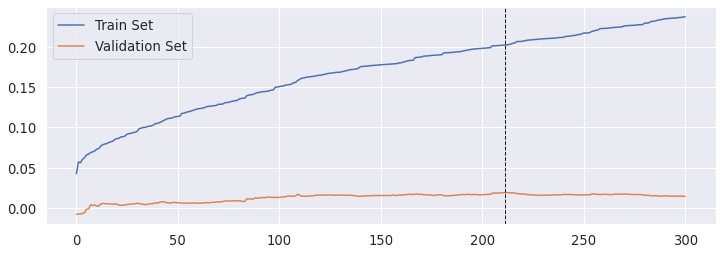

In [68]:
cv_result = pd.DataFrame({'Train Set': evals_result['train']['ic'], 
                          'Validation Set': evals_result['valid']['ic']})

ax = cv_result.loc[:300].plot(figsize=(12, 4))
ax.axvline(cv_result['Validation Set'].idxmax(), c='k', ls='--', lw=1);

## 夏普值

In [60]:
shap.initjs()

In [79]:
# model = lgb.Booster(model_file='models/lgb_model.txt')

In [61]:
explainer = shap.TreeExplainer(model)

NameError: name 'model' is not defined

In [72]:
# workaround for SHAP version 0.30: https://github.com/slundberg/shap/issues/794
model.params['objective'] = 'regression'

In [73]:
shap_values = explainer.shap_values(factors.iloc[train_idx, :].loc[:, model.feature_name()])

In [74]:
np.save(models / 'shap_values.npy', shap_values)

In [75]:
shap_values = np.load(models / 'shap_values.npy')

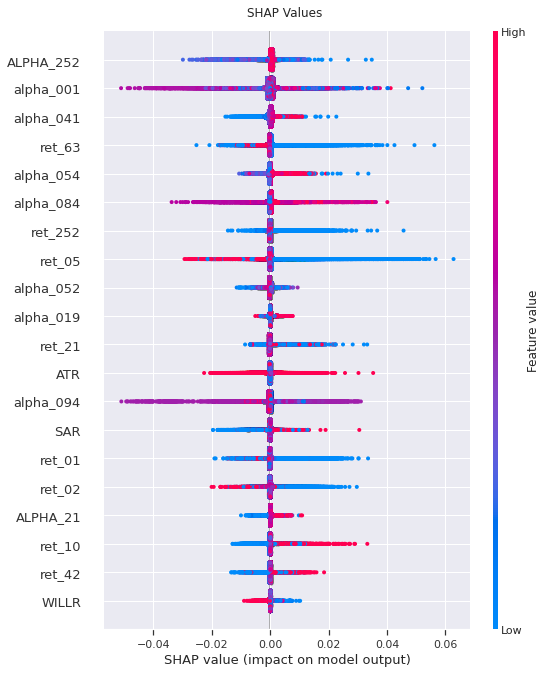

In [76]:
shap.summary_plot(shap_values,
                  factors
                  .iloc[train_idx, :]
                  .loc[:, model.feature_name()],
                  show=False)
plt.gcf().suptitle('SHAP Values')
plt.gcf().tight_layout()
plt.gcf().savefig(results_path / 'shap_summary_dot', dpi=300)

In [77]:
shap_values = pd.DataFrame(shap_values, columns = features)

## 概括

In [80]:
mi = pd.read_hdf('cn_data.h5', 'mutual_information')
fwd_corr = pd.read_hdf('cn_data.h5', 'correlation/fwd_ret')

In [81]:
shap_summary = shap_values.abs().mean()
shap_summary /= shap_summary.sum()

NameError: name 'shap_values' is not defined

In [80]:
stats = (mi.to_frame('Mutual Information')
         .join(fwd_corr.to_frame('Information Coefficient'))
         .join(fi.to_frame('Feature Importance'))
         .join(shap_summary.to_frame('SHAP Values')))

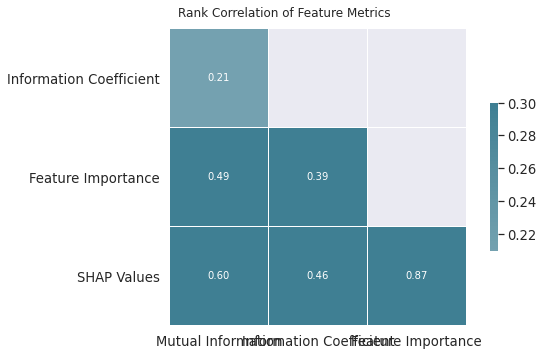

In [81]:
cols = {'Information Coefficient': stats['Information Coefficient'].abs()}
corr = stats.assign(**cols).corr('spearman')
mask = np.triu(np.ones_like(corr, dtype=np.bool))
corr = corr.iloc[1:, :-1]
mask = mask[1:, :-1]

fig, ax = plt.subplots(figsize=(8, 5))

cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')
plt.xticks(rotation=0)
fig.suptitle('Rank Correlation of Feature Metrics', fontsize=12)
fig.tight_layout()
fig.subplots_adjust(top=.92)
fig.savefig(results_path / 'metrics_correlation', dpi=300);

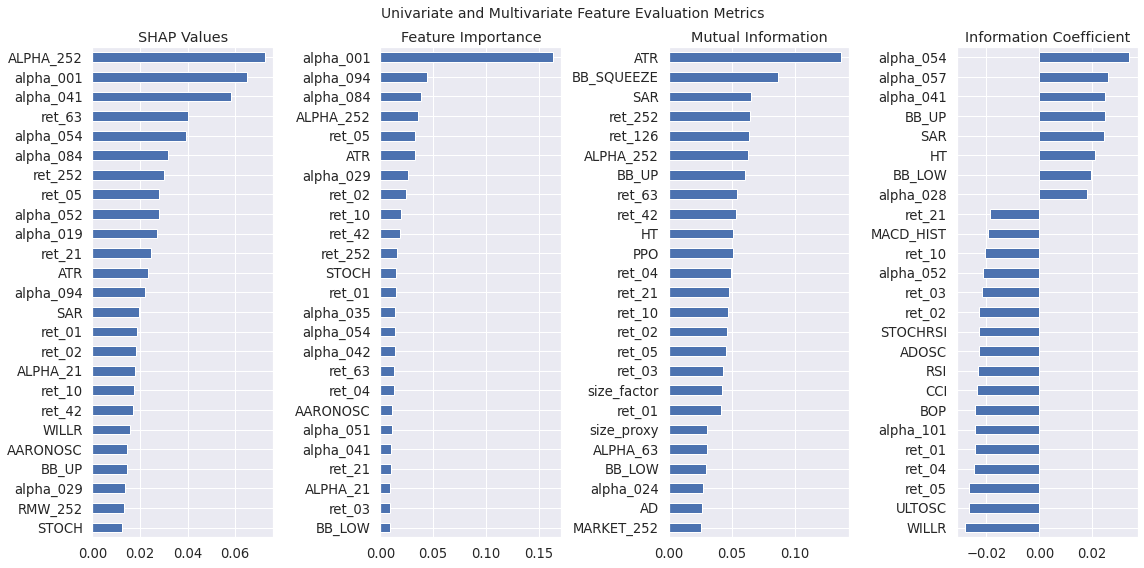

In [82]:
top_n = 25
fig, axes = plt.subplots(ncols=4, figsize=(16, 8))

shap_summary.nlargest(top_n).sort_values().plot.barh(ax=axes[0], title='SHAP Values')

fi.nlargest(top_n).sort_values().plot.barh(ax=axes[1], title='Feature Importance')

mi.nlargest(top_n).sort_values().plot.barh(ax=axes[2], title='Mutual Information')

top_corr = fwd_corr.abs().nlargest(top_n).index
fwd_corr.loc[top_corr].sort_values().plot.barh(ax=axes[3], title='Information Coefficient')

fig.suptitle('Univariate and Multivariate Feature Evaluation Metrics', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.91)
fig.savefig(results_path / 'all_feature_metrics');